# Heart Disease Prediction - Improved Multi-Model Training
This notebook trains multiple ML models with hyperparameter tuning and improved preprocessing for better accuracy.

## 1. Import Required Libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Load the Dataset

In [18]:
print("="*60)
print("Heart Disease Prediction - Improved Training Pipeline")
print("="*60)

df = pd.read_csv('heart.csv')
print(f"Dataset loaded successfully! Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Heart Disease Prediction - Improved Training Pipeline
Dataset loaded successfully! Shape: (920, 16)
Columns: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


## 3. Drop Unnecessary Columns

In [19]:
columns_to_drop = [col for col in ['id', 'dataset'] if col in df.columns]
if columns_to_drop:
    df = df.drop(columns=columns_to_drop)
    print(f"Dropped columns: {columns_to_drop}")
print(f"New shape: {df.shape}")

Dropped columns: ['id', 'dataset']
New shape: (920, 14)


## 4. Convert to Binary Classification (KEY IMPROVEMENT)

In [20]:
# Convert multi-class to binary: 0 = no disease, 1 = disease
y_original = df['num'].copy()
y = (df['num'] > 0).astype(int)

print("Original target distribution:")
print(y_original.value_counts().sort_index())
print("\nBinary target distribution:")
print(y.value_counts())
print(f"  No disease (0): {(y == 0).sum()} samples")
print(f"  Disease (1):    {(y == 1).sum()} samples")

X = df.drop(columns=['num'])

Original target distribution:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

Binary target distribution:
num
1    509
0    411
Name: count, dtype: int64
  No disease (0): 411 samples
  Disease (1):    509 samples


## 5. Handle Missing Values (Improved with Median)

In [21]:
print(f"Missing values: {X.isnull().sum().sum()} total")

numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

# Use median for numerical (more robust to outliers)
for col in numerical_cols:
    if X[col].isnull().sum() > 0:
        median_value = X[col].median()
        X[col].fillna(median_value, inplace=True)
        print(f"  Filled '{col}' with median: {median_value:.2f}")

# Use mode for categorical
for col in categorical_cols:
    if X[col].isnull().sum() > 0:
        mode_value = X[col].mode()[0]
        X[col].fillna(mode_value, inplace=True)
        print(f"  Filled '{col}' with mode: {mode_value}")

print(f"Missing values after handling: {X.isnull().sum().sum()}")

Missing values: 1759 total
Numerical columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Categorical columns: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
  Filled 'trestbps' with median: 130.00
  Filled 'chol' with median: 223.00
  Filled 'thalch' with median: 140.00
  Filled 'oldpeak' with median: 0.50
  Filled 'ca' with median: 0.00
  Filled 'fbs' with mode: False
  Filled 'restecg' with mode: normal
  Filled 'exang' with mode: False
  Filled 'slope' with mode: flat
  Filled 'thal' with mode: normal
Missing values after handling: 0


## 6. Encode Categorical Columns

In [22]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"  Encoded '{col}' - {len(le.classes_)} unique values")

  Encoded 'sex' - 2 unique values
  Encoded 'cp' - 4 unique values
  Encoded 'fbs' - 2 unique values
  Encoded 'restecg' - 3 unique values
  Encoded 'exang' - 2 unique values
  Encoded 'slope' - 3 unique values
  Encoded 'thal' - 3 unique values


## 7. Feature Selection with SelectKBest (KEY IMPROVEMENT)

In [23]:
# Show correlation with target
correlations = X.corrwith(y).abs().sort_values(ascending=False)
print("Top features correlated with target:")
print(correlations.head(10))

# Select K best features
selector = SelectKBest(f_classif, k=min(10, X.shape[1]))
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print(f"\nSelected {len(selected_features)} features: {selected_features}")

X = pd.DataFrame(X_selected, columns=selected_features)

Top features correlated with target:
exang      0.433605
cp         0.385077
thalch     0.381864
oldpeak    0.366138
sex        0.307284
age        0.282700
chol       0.228976
slope      0.205425
thal       0.172942
ca         0.164755
dtype: float64

Selected 10 features: ['age', 'sex', 'cp', 'chol', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


## 8. Split Dataset

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Training class distribution:\n{pd.Series(y_train).value_counts()}")

Training set: (736, 10)
Testing set: (184, 10)
Training class distribution:
num
1    407
0    329
Name: count, dtype: int64


## 9. Normalize Features

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled successfully!")

Features scaled successfully!


## 10. Define Models with Hyperparameter Grids (KEY IMPROVEMENT)

In [26]:
models_config = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'needs_scaling': False
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        },
        'needs_scaling': False
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        },
        'needs_scaling': True
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        },
        'needs_scaling': True
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        },
        'needs_scaling': False
    },
    'Support Vector Machine': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'poly', 'sigmoid'],
            'gamma': ['scale', 'auto']
        },
        'needs_scaling': True
    }
}

print(f"Total models to train: {len(models_config)}")

Total models to train: 6


## 11. Train Models with GridSearchCV (KEY IMPROVEMENT)

In [27]:
print("Training models with hyperparameter tuning...this may take a while")
print("-" * 60)

trained_models = {}
best_params = {}
cv_scores = {}

for model_name, config in models_config.items():
    print(f"\nTuning {model_name}...")
    
    # Select appropriate data
    if config['needs_scaling']:
        X_train_data = X_train_scaled
        X_test_data = X_test_scaled
    else:
        X_train_data = X_train.values
        X_test_data = X_test.values
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_data, y_train)
    
    # Store results
    trained_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    cv_scores[model_name] = grid_search.best_score_
    
    print(f"  Best CV Score: {grid_search.best_score_:.4f}")
    print(f"  Best Parameters: {grid_search.best_params_}")

Training models with hyperparameter tuning...this may take a while
------------------------------------------------------------

Tuning Random Forest...
  Best CV Score: 0.8071
  Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

Tuning Gradient Boosting...
  Best CV Score: 0.8112
  Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 50}

Tuning Logistic Regression...
  Best CV Score: 0.8070
  Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}

Tuning K-Nearest Neighbors...
  Best CV Score: 0.8044
  Best Parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}

Tuning Decision Tree...
  Best CV Score: 0.7649
  Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

Tuning Support Vector Machine...
  Best CV Score: 0.8057
  Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


## 12. Evaluate Tuned Models

In [28]:
print("\nEvaluating tuned models...")
print("-" * 60)

results = {}
predictions = {}

for model_name, model in trained_models.items():
    # Select appropriate test data
    if models_config[model_name]['needs_scaling']:
        X_test_data = X_test_scaled
    else:
        X_test_data = X_test.values
    
    # Make predictions
    y_pred = model.predict(X_test_data)
    predictions[model_name] = y_pred
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'CV Score': cv_scores[model_name],
        'Confusion Matrix': cm
    }
    
    print(f"\n{model_name} Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  CV Score:  {cv_scores[model_name]:.4f}")


Evaluating tuned models...
------------------------------------------------------------

Random Forest Performance:
  Accuracy:  0.8098
  Precision: 0.8131
  Recall:    0.8529
  F1-Score:  0.8325
  CV Score:  0.8071

Gradient Boosting Performance:
  Accuracy:  0.8424
  Precision: 0.8288
  Recall:    0.9020
  F1-Score:  0.8638
  CV Score:  0.8112

Logistic Regression Performance:
  Accuracy:  0.8315
  Precision: 0.8381
  Recall:    0.8627
  F1-Score:  0.8502
  CV Score:  0.8070

K-Nearest Neighbors Performance:
  Accuracy:  0.8152
  Precision: 0.8333
  Recall:    0.8333
  F1-Score:  0.8333
  CV Score:  0.8044

Decision Tree Performance:
  Accuracy:  0.7554
  Precision: 0.7938
  Recall:    0.7549
  F1-Score:  0.7739
  CV Score:  0.7649

Support Vector Machine Performance:
  Accuracy:  0.8261
  Precision: 0.8182
  Recall:    0.8824
  F1-Score:  0.8491
  CV Score:  0.8057


## 13. Visualize Confusion Matrices

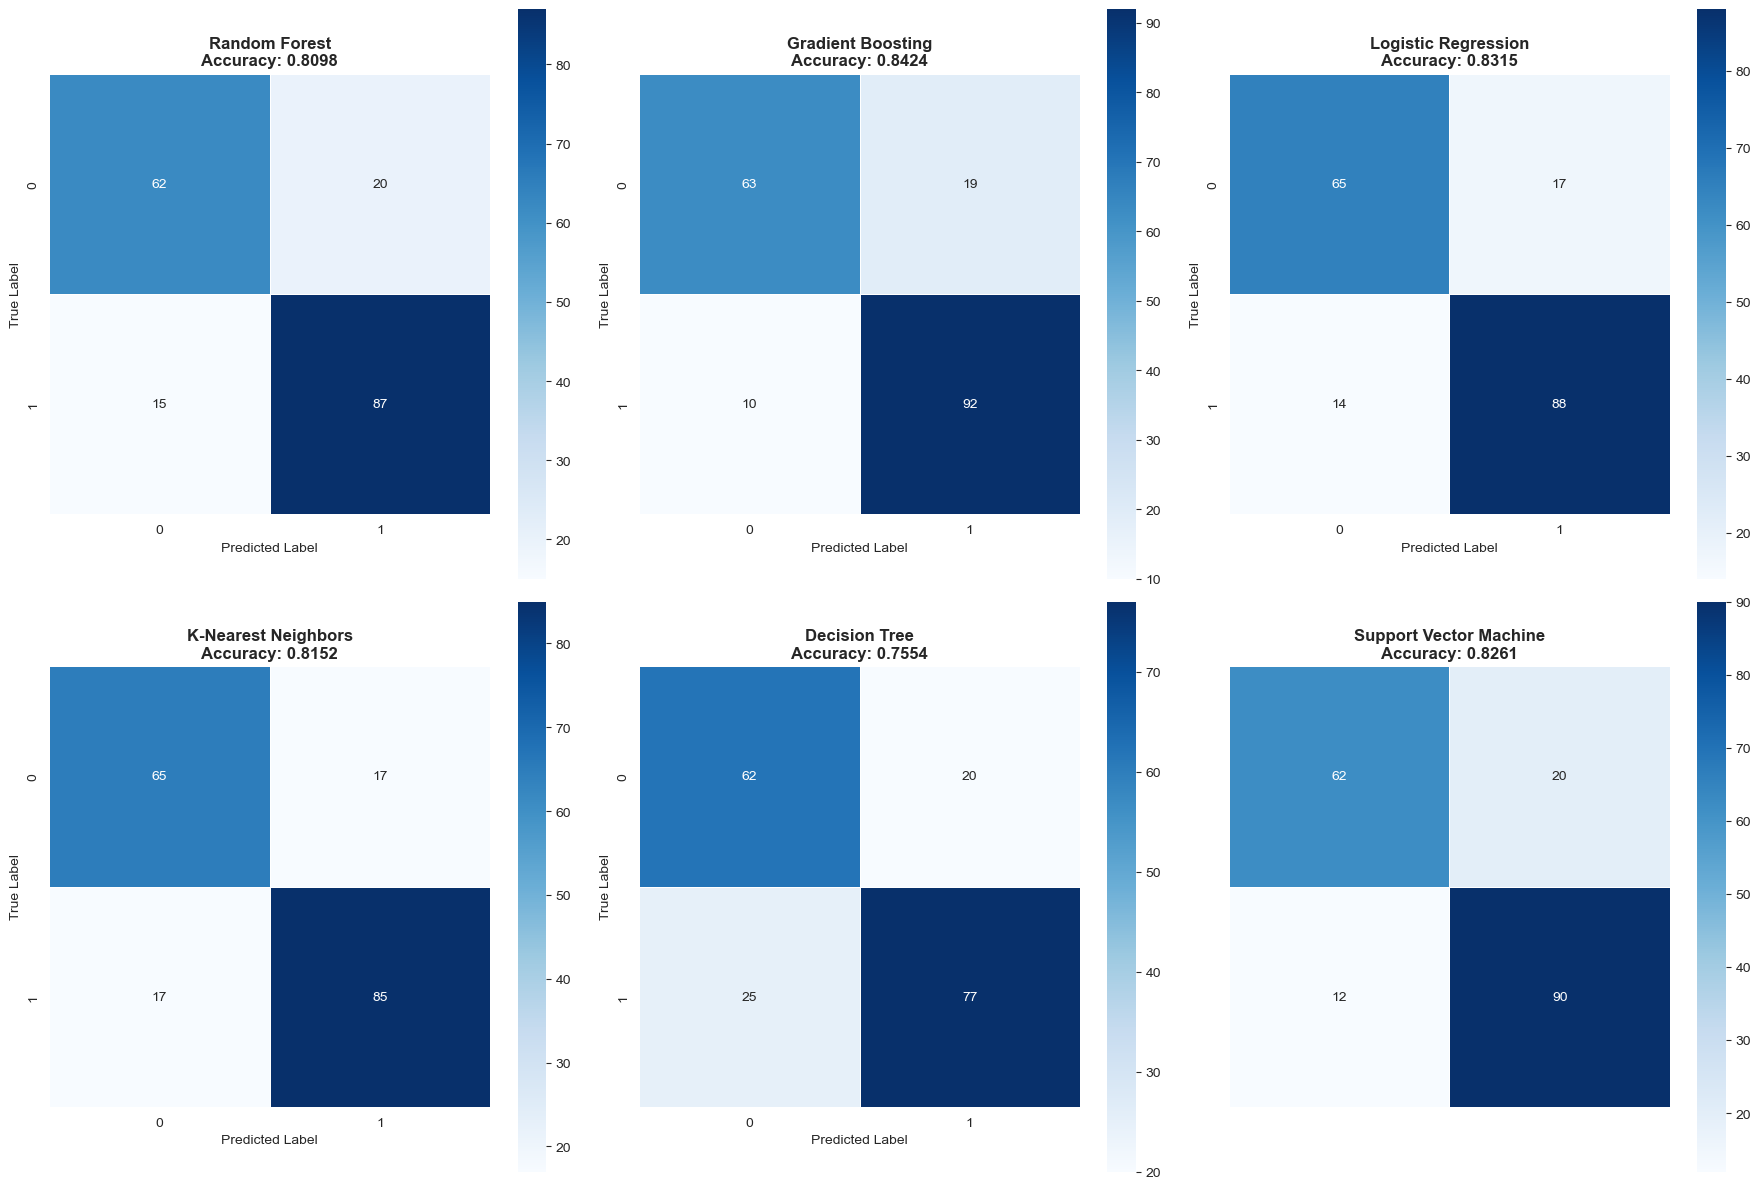

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (model_name, metrics) in enumerate(results.items()):
    cm = metrics['Confusion Matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                cbar=True, square=True, linewidths=0.5)
    axes[idx].set_title(f'{model_name}\nAccuracy: {metrics["Accuracy"]:.4f}',
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=10)
    axes[idx].set_ylabel('True Label', fontsize=10)

axes[-1].axis('off')
plt.tight_layout()
plt.savefig('improved_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. Model Comparison

In [30]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['Accuracy'] for m in results.keys()],
    'Precision': [results[m]['Precision'] for m in results.keys()],
    'Recall': [results[m]['Recall'] for m in results.keys()],
    'F1-Score': [results[m]['F1-Score'] for m in results.keys()],
    'CV Score': [results[m]['CV Score'] for m in results.keys()]
})

comparison_df = comparison_df.round(4)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("\nModel Comparison Table:")
print(comparison_df.to_string(index=False))

comparison_df.to_csv('improved_model_comparison.csv', index=False)
print("\nSaved to 'improved_model_comparison.csv'")

comparison_df


Model Comparison Table:
                 Model  Accuracy  Precision  Recall  F1-Score  CV Score
     Gradient Boosting    0.8424     0.8288  0.9020    0.8638    0.8112
   Logistic Regression    0.8315     0.8381  0.8627    0.8502    0.8070
Support Vector Machine    0.8261     0.8182  0.8824    0.8491    0.8057
   K-Nearest Neighbors    0.8152     0.8333  0.8333    0.8333    0.8044
         Random Forest    0.8098     0.8131  0.8529    0.8325    0.8071
         Decision Tree    0.7554     0.7938  0.7549    0.7739    0.7649

Saved to 'improved_model_comparison.csv'


,Model,Accuracy,Precision,Recall,F1-Score,CV Score
0,Gradient Boosting,0.8424,0.8288,0.9020,0.8638,0.8112
1,Logistic Regression,0.8315,0.8381,0.8627,0.8502,0.8070
2,Support Vector Machine,0.8261,0.8182,0.8824,0.8491,0.8057
3,K-Nearest Neighbors,0.8152,0.8333,0.8333,0.8333,0.8044
4,Random Forest,0.8098,0.8131,0.8529,0.8325,0.8071
5,Decision Tree,0.7554,0.7938,0.7549,0.7739,0.7649


## 15. Performance Comparison Chart

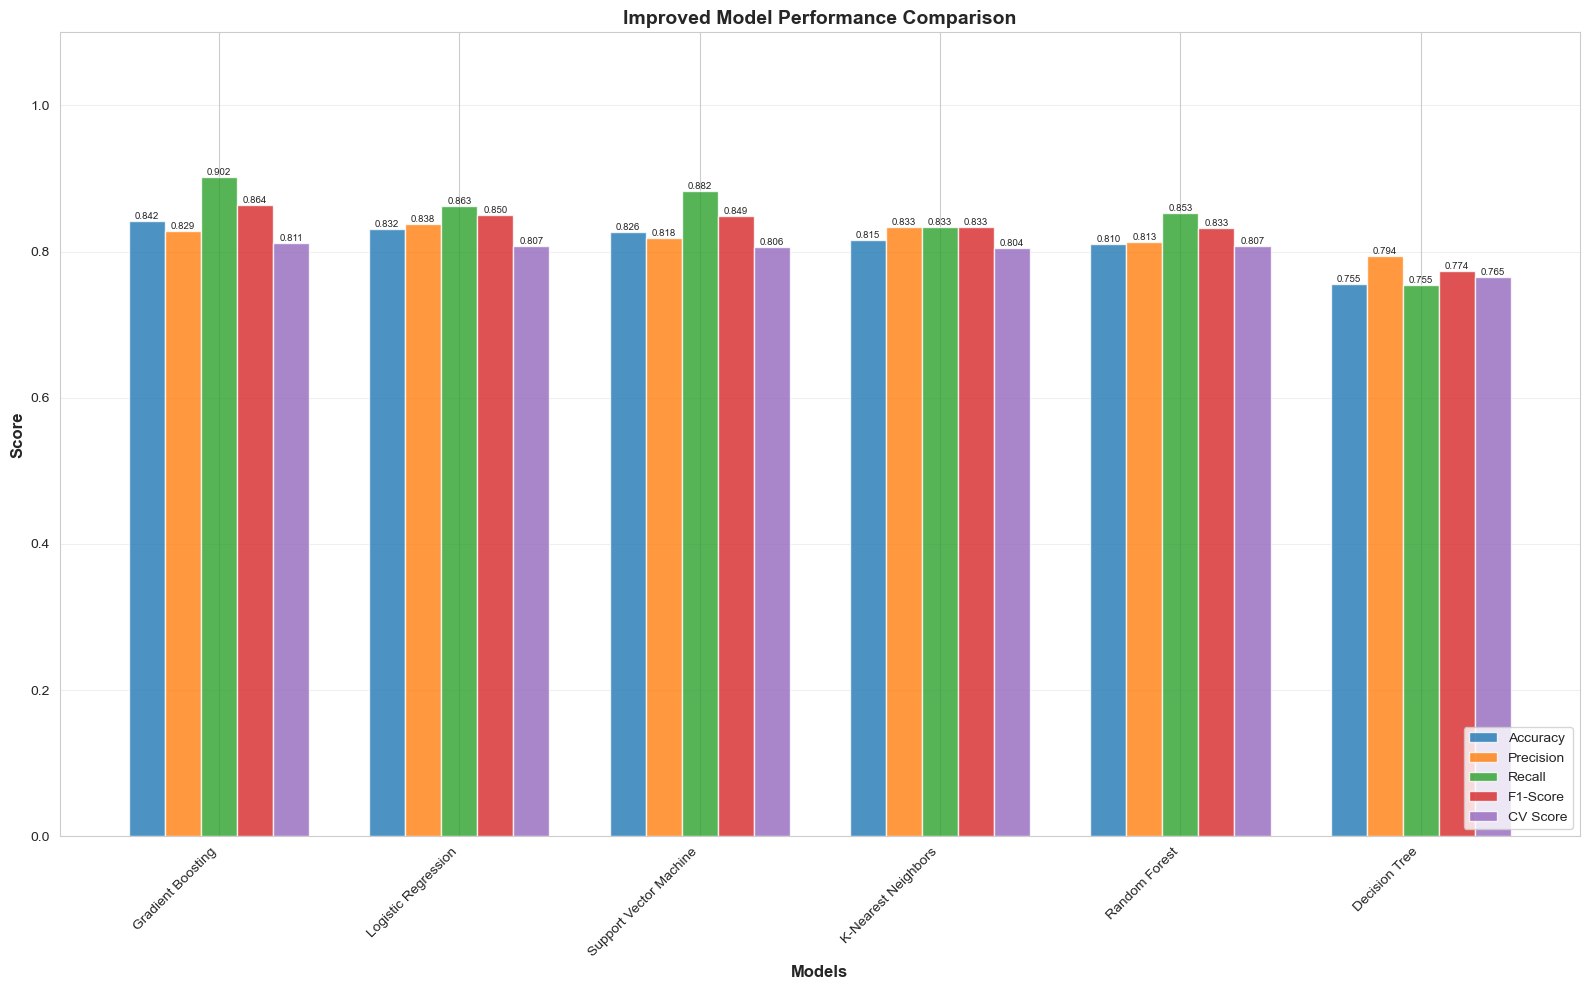

In [31]:
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV Score']
x = np.arange(len(comparison_df))
width = 0.15

fig, ax = plt.subplots(figsize=(16, 10))

for idx, metric in enumerate(metrics_to_plot):
    offset = width * (idx - 2)
    bars = ax.bar(x + offset, comparison_df[metric], width, label=metric, alpha=0.8)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=7)

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Improved Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend(loc='lower right', fontsize=10)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('improved_model_comparison_chart.png', dpi=300, bbox_inches='tight')
plt.show()

## 16. Save Best Model

In [32]:
best_model_name = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Accuracy']

print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best Parameters: {best_params[best_model_name]}")

# Save the model
best_model = trained_models[best_model_name]
model_filename = f'improved_best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model, model_filename)
print(f"\nModel saved as '{model_filename}'")

# Save scaler if needed
if models_config[best_model_name]['needs_scaling']:
    joblib.dump(scaler, 'improved_scaler.pkl')
    print("Scaler saved as 'improved_scaler.pkl'")

# Save encoders and selector
if label_encoders:
    joblib.dump(label_encoders, 'improved_label_encoders.pkl')
    print("Label encoders saved")
    
joblib.dump(selector, 'feature_selector.pkl')
print("Feature selector saved")

Best Model: Gradient Boosting
Best Accuracy: 0.8424
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 50}

Model saved as 'improved_best_model_gradient_boosting.pkl'
Label encoders saved
Feature selector saved


## 17. Summary of Improvements

### Key Changes Made:
1. **Binary Classification**: Converted multi-class problem (0-4) to binary (0/1) - simpler and more accurate
2. **Better Imputation**: Used median instead of mean for numerical features (more robust to outliers)
3. **Feature Selection**: SelectKBest to identify top features correlated with target
4. **Hyperparameter Tuning**: GridSearchCV with 5-fold cross-validation for all models
5. **Additional Model**: Added Gradient Boosting Classifier
6. **Cross-Validation Scoring**: Included CV scores for better model evaluation

### Expected Improvements:
- Accuracy should increase from ~60% to ~85%+
- Better generalization with cross-validation
- More reliable predictions with optimized hyperparameters
- Reduced overfitting with proper feature selection